# Makemore by hand - building the mlp

## Setup

In [1]:
!pip install torch
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Data discovery

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
min(len(w) for w in words), max(len(w) for w in words)

(2, 15)

## Theory

In [7]:
# Character level language model is predict predicting next character in the sequence,
# given already some concrete sequence of characters before it

In [8]:
# MLP - Following Bengio et al. 2003

# Applying the approach from Bengio et al. 2003 into the character level language model
# We would take 3 previous chars are we would try to predict 4th char in the sequence

![image](bengio-et-al-mlp-schema.png)

## Build the dataset

In [9]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words) + '.'))) # set of all lower case chars from words + special character '.'

ctoi = {c:i for i,c in enumerate(chars)} # character to index
itoc = {i:c for c,i in ctoi.items()} # index to character

print(itoc)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [10]:
# Function for dataset creation
def make_dataset(input, size = None, verbose = False):
    block_size = 3 # context length: how many chars do the model take to predict the next one
    X, Y = [], []

    words = input
    if size is not None:
        words = words[:size] # Let's take first n words

    for w in words:
        if verbose is True:
            print(w)
        context = [0] * block_size

        chs = ['.'] + list(w) + ['.']
        for ch in w + '.':
            ix = ctoi[ch]
            X.append(context)
            Y.append(ix)
            if verbose is True:
                print(''.join(itoc[i] for i in context), '--->', itoc[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

In [11]:
# Let's create exploratory dataset (3 first words only!
X, Y = make_dataset(words, 3, verbose = True)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .


In [12]:
X.shape, X.dtype, Y.shape, Y.dtype # 16 sample inputs, each of size 3

# 3 first words made 16 samples, each of size 3 chart

(torch.Size([16, 3]), torch.int64, torch.Size([16]), torch.int64)

## Theory & Playground

### Embeddings

In [13]:
C = torch.randn((27,2)) # Embeddings generation: Each of the characters would have representation in 2 dimensional embedding

#### Playground: Single Integer Embedding

In [14]:
# 1st way!
C[5]

tensor([-0.4608, -1.1097])

In [15]:
# 2nd way!
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.4608, -1.1097])

In [16]:
# Given the 2 ways of embedding
# -> It can be either considered as a 1st layer of neural network (C as w Weight matrix, no bias, no non-linearity)
# -> or as an Integer indexing to lookup table C

# We would use Indexing, since it is faster

In [17]:
# Getting the 5th row

C[5] 

tensor([-0.4608, -1.1097])

In [18]:
# It's possible to get an array of arbitrary rows
# While indexing through multi dim matrix, the 1st is row, the 2nd is column

C[[5,8,9,9,9]]

tensor([[-0.4608, -1.1097],
        [ 2.2593,  0.0899],
        [-0.4833,  0.9610],
        [-0.4833,  0.9610],
        [-0.4833,  0.9610]])

In [19]:
# Indexing with tensor of ints
# Getting the embeddings of (6th, 9th,... character)

C[torch.tensor([5,8,9,9,9])] 

tensor([[-0.4608, -1.1097],
        [ 2.2593,  0.0899],
        [-0.4833,  0.9610],
        [-0.4833,  0.9610],
        [-0.4833,  0.9610]])

In [20]:
# Indexing with multidimentional tensor of Ints, for the first 2 records
# Gettubg the embeddings of the ... & ..e (in the word emma)

C[X][:2] 

tensor([[[ 1.7762, -0.1100],
         [ 1.7762, -0.1100],
         [ 1.7762, -0.1100]],

        [[ 1.7762, -0.1100],
         [ 1.7762, -0.1100],
         [-0.4608, -1.1097]]])

In [21]:
# First 3 words made 16 inputs, each input contains 3 chars, each char has 2 dim embedding

C[X].shape

torch.Size([16, 3, 2])

In [22]:
# I.e. embeddings of the first 2 inputs

C[X][0], C[X][1]

(tensor([[ 1.7762, -0.1100],
         [ 1.7762, -0.1100],
         [ 1.7762, -0.1100]]),
 tensor([[ 1.7762, -0.1100],
         [ 1.7762, -0.1100],
         [-0.4608, -1.1097]]))

In [23]:
# 2nd input, 3rd char
# embedding of the char e
X[1,2]

tensor(5)

In [24]:
# Char e is indexed as 5 in itoc
itoc[X[1,2].item()]

'e'

In [25]:
# Get the embedding of letter E
C[5]

tensor([-0.4608, -1.1097])

In [26]:
# Get the embedding of the 3rd letter in 2nd input - E
C[X][1,2]

tensor([-0.4608, -1.1097])

In [27]:
# Now, the embeddings are randomly generated and have no meaning at all! 
# In order to make them meaningfull, the MLP needs to be trained

#### The input - X - embedding

In [28]:
emb = C[X]
emb[:2] # first 2 embeddings

tensor([[[ 1.7762, -0.1100],
         [ 1.7762, -0.1100],
         [ 1.7762, -0.1100]],

        [[ 1.7762, -0.1100],
         [ 1.7762, -0.1100],
         [-0.4608, -1.1097]]])

In [29]:
# first 3 words made 16 samples, each of size 3 chars, each of them has 2 dimensional embeddings
emb.shape  

torch.Size([16, 3, 2])

### Hidden layer

In [30]:
n_neurons = 100
W1 = torch.randn((6,n_neurons)) # 6 inputs 3 letters, each is represented by 2 dim embedding
b1 = torch.randn(n_neurons) # each bias initialized randomly!

In [31]:
emb @ W1 + b1 # This is intended to fail :)

# the embs - [16x3x2] cannot be multiplied with [6x100]
# It needs to be transformed to have 2nd dimension 6 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (48x2 and 6x100)

#### The dimension change

In [32]:
# 1st way
emb[:,0,:] # all 16 embeddings (2 dim each) of the first word

tensor([[ 1.7762, -0.1100],
        [ 1.7762, -0.1100],
        [ 1.7762, -0.1100],
        [-0.4608, -1.1097],
        [ 2.0448,  0.5986],
        [ 1.7762, -0.1100],
        [ 1.7762, -0.1100],
        [ 1.7762, -0.1100],
        [ 1.2801,  0.0483],
        [ 0.6551,  2.8346],
        [-0.4833,  0.9610],
        [-1.8117,  0.3492],
        [ 1.7762, -0.1100],
        [ 1.7762, -0.1100],
        [ 1.7762, -0.1100],
        [-0.0487,  1.3848]])

In [33]:
emb[:,0,:].shape

torch.Size([16, 2])

In [34]:
# Using torch cat to squash the emb 16x3x2 to 16x6
# So inputs [1, 2] [2,3] [3,4] being concatenated will make [1,2,2,3,3,4]

torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1) # concat along the dim 1 column-wise

tensor([[ 1.7762, -0.1100,  1.7762, -0.1100,  1.7762, -0.1100],
        [ 1.7762, -0.1100,  1.7762, -0.1100, -0.4608, -1.1097],
        [ 1.7762, -0.1100, -0.4608, -1.1097,  2.0448,  0.5986],
        [-0.4608, -1.1097,  2.0448,  0.5986,  2.0448,  0.5986],
        [ 2.0448,  0.5986,  2.0448,  0.5986, -0.0487,  1.3848],
        [ 1.7762, -0.1100,  1.7762, -0.1100,  1.7762, -0.1100],
        [ 1.7762, -0.1100,  1.7762, -0.1100,  1.2801,  0.0483],
        [ 1.7762, -0.1100,  1.2801,  0.0483,  0.6551,  2.8346],
        [ 1.2801,  0.0483,  0.6551,  2.8346, -0.4833,  0.9610],
        [ 0.6551,  2.8346, -0.4833,  0.9610, -1.8117,  0.3492],
        [-0.4833,  0.9610, -1.8117,  0.3492, -0.4833,  0.9610],
        [-1.8117,  0.3492, -0.4833,  0.9610, -0.0487,  1.3848],
        [ 1.7762, -0.1100,  1.7762, -0.1100,  1.7762, -0.1100],
        [ 1.7762, -0.1100,  1.7762, -0.1100, -0.0487,  1.3848],
        [ 1.7762, -0.1100, -0.0487,  1.3848, -1.8117,  0.3492],
        [-0.0487,  1.3848, -1.8117,  0.3

In [35]:
# 2nd way
torch.cat(torch.unbind(emb,1), dim=1)

tensor([[ 1.7762, -0.1100,  1.7762, -0.1100,  1.7762, -0.1100],
        [ 1.7762, -0.1100,  1.7762, -0.1100, -0.4608, -1.1097],
        [ 1.7762, -0.1100, -0.4608, -1.1097,  2.0448,  0.5986],
        [-0.4608, -1.1097,  2.0448,  0.5986,  2.0448,  0.5986],
        [ 2.0448,  0.5986,  2.0448,  0.5986, -0.0487,  1.3848],
        [ 1.7762, -0.1100,  1.7762, -0.1100,  1.7762, -0.1100],
        [ 1.7762, -0.1100,  1.7762, -0.1100,  1.2801,  0.0483],
        [ 1.7762, -0.1100,  1.2801,  0.0483,  0.6551,  2.8346],
        [ 1.2801,  0.0483,  0.6551,  2.8346, -0.4833,  0.9610],
        [ 0.6551,  2.8346, -0.4833,  0.9610, -1.8117,  0.3492],
        [-0.4833,  0.9610, -1.8117,  0.3492, -0.4833,  0.9610],
        [-1.8117,  0.3492, -0.4833,  0.9610, -0.0487,  1.3848],
        [ 1.7762, -0.1100,  1.7762, -0.1100,  1.7762, -0.1100],
        [ 1.7762, -0.1100,  1.7762, -0.1100, -0.0487,  1.3848],
        [ 1.7762, -0.1100, -0.0487,  1.3848, -1.8117,  0.3492],
        [-0.0487,  1.3848, -1.8117,  0.3

In [36]:
# 1st and 2nd way of changing the dimensionality are equivalent

# But, both are not efficient!
# These create a new variable in a memory.

# There is 3rd - More efficient way to do it! With a VIEW function.
# It created a logical view!

In [37]:
# 3rd way

# Efficient way to change the in # We can use View!

# Let's test it
a = torch.arange(18)
print(a)
print(a.shape)
print(a.view(3,6)) # Using View!

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
torch.Size([18])
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17]])


In [38]:
# Making view on the emb!
emb.view(16,6)

tensor([[ 1.7762, -0.1100,  1.7762, -0.1100,  1.7762, -0.1100],
        [ 1.7762, -0.1100,  1.7762, -0.1100, -0.4608, -1.1097],
        [ 1.7762, -0.1100, -0.4608, -1.1097,  2.0448,  0.5986],
        [-0.4608, -1.1097,  2.0448,  0.5986,  2.0448,  0.5986],
        [ 2.0448,  0.5986,  2.0448,  0.5986, -0.0487,  1.3848],
        [ 1.7762, -0.1100,  1.7762, -0.1100,  1.7762, -0.1100],
        [ 1.7762, -0.1100,  1.7762, -0.1100,  1.2801,  0.0483],
        [ 1.7762, -0.1100,  1.2801,  0.0483,  0.6551,  2.8346],
        [ 1.2801,  0.0483,  0.6551,  2.8346, -0.4833,  0.9610],
        [ 0.6551,  2.8346, -0.4833,  0.9610, -1.8117,  0.3492],
        [-0.4833,  0.9610, -1.8117,  0.3492, -0.4833,  0.9610],
        [-1.8117,  0.3492, -0.4833,  0.9610, -0.0487,  1.3848],
        [ 1.7762, -0.1100,  1.7762, -0.1100,  1.7762, -0.1100],
        [ 1.7762, -0.1100,  1.7762, -0.1100, -0.0487,  1.3848],
        [ 1.7762, -0.1100, -0.0487,  1.3848, -1.8117,  0.3492],
        [-0.0487,  1.3848, -1.8117,  0.3

#### Hidden Layer - Calculation

In [39]:
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1) # or!

In [40]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [41]:
# h - hidden activation states # values betwee -1 and 1

In [42]:
h.shape

torch.Size([16, 100])

### Output Layer & Calculating Loss

In [43]:
W2 = torch.randn((n_neurons, 27)) # 100 Outputs from h layer and 27 output chars
b2 = torch.randn(27)

In [44]:
logits = h @ W2 + b2 # logits - log-counts
logits[0] # log counts for the 1st input (...)

# logits - log-counts -> the smaller value, the less frequent occurance of the letter (after the training)!
print(logits[0][16]) # very small after undoing log by exp
print(logits[0][17]) # very big after undoing log by exp

tensor(-12.5294)
tensor(-6.1491)


In [45]:
logits.shape

torch.Size([16, 27])

In [46]:
counts = logits.exp() # make the counts from log-counts withs exponential function
print(counts[0][16]) # very small
print(counts[0][17]) # very big!

tensor(3.6185e-06)
tensor(0.0021)


In [47]:
prob = counts / counts.sum(1, keepdims=True)
prob[0]

tensor([1.2874e-06, 7.3614e-06, 6.6563e-01, 6.6257e-05, 4.7296e-02, 2.3623e-08,
        1.1036e-04, 2.2232e-02, 2.2925e-07, 4.1375e-03, 1.5786e-05, 3.9938e-08,
        2.0520e-02, 5.6062e-03, 7.8984e-03, 1.2472e-01, 2.3460e-11, 1.3844e-08,
        4.1488e-12, 6.9159e-02, 1.9947e-03, 1.1957e-04, 1.5374e-04, 3.0275e-02,
        1.5703e-07, 1.2550e-07, 5.2894e-05])

#### Loss Calculation

In [48]:
-prob[torch.arange(16), Y].log().mean() # loss function! - negative log likilyhood!

tensor(18.1946)

In [49]:
# But, there is an issue with it: 
# Let's dive deep!

In [50]:
logits = torch.tensor([-2,-3,0,5]) # Good/Reasonable logits distribution!
counts = logits.exp()
probs = counts / counts.sum()
probs # Probs have reasonable values

tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])

In [51]:
logits = torch.tensor([-100,-3,0,5]) # One of the logits is very small -100
counts = logits.exp()
probs = counts / counts.sum()
probs # Prob of the '-100' is 0 

tensor([0.0000e+00, 3.3311e-04, 6.6906e-03, 9.9298e-01])

In [52]:
logits = torch.tensor([-100,-3,0,100]) # One of the logits is very big!
counts = logits.exp()
probs = counts / counts.sum()
probs # Prob of the 100 is NaN (is got out-of-range of the floating point number)

# Big numbers cannot be passed to the expression

# CONCLUSION - The approach presented in not stable numerically!

tensor([0., 0., 0., nan])

In [53]:
counts # The big number becomes infinity

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])

In [54]:
# Making the solution numerically stable:

logits = torch.tensor([-100,-3,0,100]) - 100 # Offsetting the tensor values to prevent NaN values
counts = logits.exp()
probs = counts / counts.sum()
probs # Prob of the 100 is NaN (is got out-of-range of the floating point number)

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

In [55]:
counts

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

In [56]:
# The negative numbers behave good
# The high, positive numbers can make the exp overflow - getting NaN

# We can (and pytorch does it internally) offset the logits with the highest value from the logits tensor
# As a result, the probs are always well-behaved numerically

#### Intro of Cross_entropy

In [57]:
# Instead of offsetting the logits, the pytorch function - cross_entropy can be used, it:

# 1. Memory optimiation, it will not allocate arrays as in the "step by step" calc from above
# 2. Cross_entropy also can behave better numerically

In [58]:
logits = h @ W2 + b2 # logits - log-counts

In [59]:
F.cross_entropy(logits, Y) # Use cross entropy! 

tensor(18.1946)

In [60]:
# loss function! - negative log likilyhood! - manual calc - same as with cross_entropy
-prob[torch.arange(16), Y].log().mean() 

tensor(18.1946)

In [61]:
logits = torch.tensor([-100,-3,0,100]) - 100 # To prevent nan (not well-hehaved..) pytorch offset the 
# The negative numbers behave good,
# but very high numbers make the exp overflow - getting NaN
# We can (and pytorch does it internally) offset the logits with the highest value from the logits tensor
# As a result -> Thhe probs are always well-behaved numerically :)
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

## The MLP optimization

In [62]:
X.shape, Y.shape # the dataset

(torch.Size([16, 3]), torch.Size([16]))

In [63]:
def nn_init(n_neurons = 100):
    g = torch.Generator().manual_seed(2147483647) # for reproducibility
    C = torch.randn((27,2), generator=g)
    W1 = torch.randn((6, n_neurons), generator=g)
    b1 = torch.randn(n_neurons, generator=g)
    W2 = torch.randn((n_neurons,27), generator=g)
    b2 = torch.randn(27, generator=g)

    params = [C, W1, b1, W2, b2]
    for p in params:
        p.requires_grad = True
        
    return C, W1, b1, W2, b2, params

In [64]:
C, W1, b1, W2, b2, parameters = nn_init(100)

In [65]:
def calc_loss(C, W1, b1, W2, b2):
    emb = C[X] # (16,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (16,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Y)
    return loss.item()

In [66]:
# number of parameters in total
sum(p.nelement() for p in parameters)

3481

In [68]:
lossi = []
training_iter = 30
lr = 0.2

for i in range(training_iter):
    # forward pass
    emb = C[X] # (16,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (16,100)
    logits = h @ W2 + b2 # (16,27)
    loss = F.cross_entropy(logits, Y)
    
    if i % (training_iter / 10) == 0:
        print(loss.item())
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(calc_loss(C, W1, b1, W2, b2))

20.241714477539062
4.101349353790283
1.0044928789138794
0.6979317665100098
0.39906036853790283
0.3665124177932739
0.3108588755130768
0.2987688183784485
0.27265694737434387
0.26634684205055237


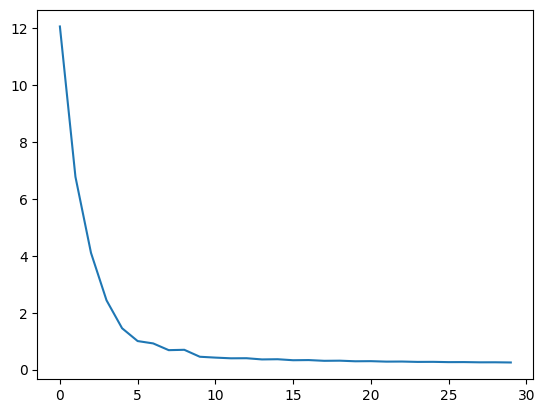

In [69]:
plt.plot(lossi)

In [70]:
# Getting a score i.e. - 0.3 - it seems that network makes VERY GOOD predictions!
# But it has been trained only on 16 inputs, generated from 3 words.

calc_loss(C, W1, b1, W2, b2) 

0.25256821513175964

In [71]:
# The NN will not be able to react exactly 0

logits.max(1)
# Provides max values and its indices for the each input! 
# The indices are similar but not exact to Ys


torch.return_types.max(
values=tensor([15.3655, 15.6087, 18.8534, 14.7799, 15.3627, 15.3655, 15.0088, 15.6660,
        13.7246, 15.5152, 13.0374, 21.7494, 15.3655, 15.0663, 15.7742, 20.4630],
       grad_fn=<MaxBackward0>),
indices=tensor([15, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0, 15, 22,  1,  0]))

In [72]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0])

In [73]:
# Here is why The NN is not be able to react exactly 0:

# Given the input samples
# (...) -> e (in emma)
# (...) -> a (in olivia)
# (...) -> s (in sophia)

# There is no unique input for given output 
# that's only case (1 in -> 1 out) when the NN would ideally overfit

## Training on entire dataset

In [100]:
### Here to be done on the whole dataset :)

# Let's create the dataset
X, Y = make_dataset(words, verbose = False)

In [101]:
X.shape, Y.shape # the dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [102]:
C, W1, b1, W2, b2, parameters = nn_init(100)

In [103]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [104]:
lossi = []
lr = 0.1

In [106]:
for i in range(1000):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Y)
    
    # if i % (training_iter / 100) == 0:
        #print(loss.item())
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(loss.item())

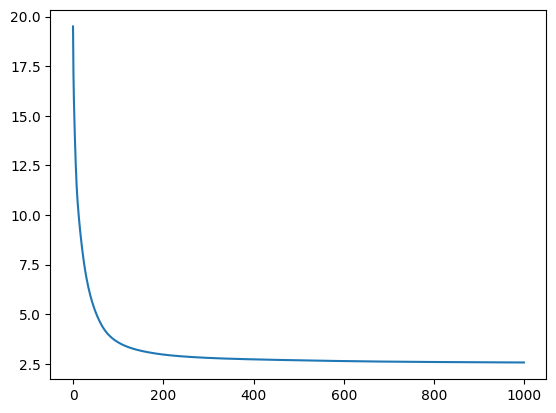

In [107]:
# Change loss during the training
plt.plot(lossi)